This notebook analysis the performance of the classifier in terms of response speed: i.e. how fast can the module identify a TDE with respect to its first observation and its peak.


## 1. Load data

In [3]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pprint import pprint
import seaborn as sns
import itertools

from early_tde_classification.config import Config

def separate_features_and_labels(feat_data):

    # Get labels: Modify the tns_label column to classify as 'TDE' or 'nonTDE'
    feat_data['tde_or_not'] = feat_data['tns_label'].apply(
        lambda x: 'TDE' if 'TDE' in str(x) else 'nonTDE')
    labels = feat_data['tde_or_not']
    
    # Keep only columns that are used for the model (feature_matrix)

    features_to_keep = ['amplitude', 'rise_time', 'temperature', 'r_chisq', 'sigmoid_dist',
       'snr_rise_time', 'snr_amplitude']
    feature_matrix = feat_data.copy()[features_to_keep]
    return feature_matrix, labels
    
feat_data = pd.read_csv('features_with_tns_labels.csv')
feature_matrix, labels = separate_features_and_labels(feat_data)


## Proceed with (RF) classifier
Do Training and Testing steps of the model and plot lightcurve with identified alerts.




In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
def train_test_split_on_objectId(feat_data, feature_matrix, labels, test_size = 0.3, random_state = None, verbose = False):
    """
    Split into train and test, considering the object IDs (not just the alerts).
    So that alerts from the same object cannot be in both training and testing.
    """

    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    all_ids = np.unique(feat_data['objectId'])
    tde_ids = np.unique(feat_data.loc[feat_data['tde_or_not']=='TDE', 'objectId'])
    nontde_ids = np.unique(feat_data.loc[feat_data['tde_or_not']=='nonTDE', 'objectId'])

    nontdes_test_ids = np.random.choice(nontde_ids, size=int(test_size*len(nontde_ids)), replace=False)
    tde_test_ids = np.random.choice(tde_ids, size=int(test_size*len(tde_ids)), replace=False)
    test_ids = list(nontdes_test_ids) + list(tde_test_ids)
    
    test_mask = feat_data['objectId'].isin(test_ids)
    X_train = feature_matrix[~test_mask]
    X_test = feature_matrix[test_mask]
    y_train = labels[~test_mask]
    y_test = labels[test_mask]
    if verbose:
        print('Test size fraction of {} in terms of objects\n'.format(test_size),
        'Fraction of alerts in training: {0:.2f}; and in testing: {1:.2f}\n\n'.format(len(y_train)/len(labels), len(y_test)/len(labels)))

    return X_train, X_test, y_train, y_test, test_mask

    

In [4]:
def train_and_predict(feat_data, feature_matrix, labels, random_state, verbose = False):
    # Split train test samples
    X_train, X_test, y_train, y_test, test_mask = train_test_split_on_objectId(feat_data, feature_matrix, labels,
                                                                               test_size=0.3, random_state = random_state, verbose = verbose)
    # Create a shallow Decision Tree Classifier
    shallow_rf = RandomForestClassifier(random_state=random_state, class_weight='balanced',
                                 n_jobs=10, n_estimators=100, max_depth=8)
    
    # Train the classifier
    shallow_rf.fit(X_train, y_train)
    
    # Predict on the test set
    label_pred = shallow_rf.predict(X_test)

    if verbose:
        # Evaluate the classifier
        print("Accuracy:", accuracy_score(y_test, label_pred))
        print("\nClassification Report:\n", classification_report(y_test, label_pred))

    return label_pred, y_test, test_mask
label_pred, label_test, test_mask = train_and_predict(feat_data, feature_matrix, labels, 1, verbose = True)

Test size fraction of 0.3 in terms of objects
 Fraction of alerts in training: 0.69; and in testing: 0.31


Accuracy: 0.9938779414578152

Classification Report:
               precision    recall  f1-score   support

         TDE       0.63      0.77      0.69        47
      nonTDE       1.00      1.00      1.00      5180

    accuracy                           0.99      5227
   macro avg       0.81      0.88      0.84      5227
weighted avg       0.99      0.99      0.99      5227



In [5]:
# Get the identified TDE candidates (that are actual TDEs)
pred_tdes = feat_data[test_mask][(label_test == 'TDE') & (label_pred == 'TDE')]
# pred_tdes = feat_data[test_mask][(label_pred == 'TDE')]
pred_tdes_objectid = pred_tdes.objectId.unique().tolist()
# pred_tdes_alertid = pred_tdes.alertId.tolist()

In [6]:
from early_tde_classification.extract_features import load_extragalatic_data_full_lightcurves as load_lcs
tde_lcs = load_lcs(object_list = pred_tdes_objectid)


### Plot lightcurves highlighting identified alerts


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_fluxcal(df, pred_tdes_alertid):
    # Filter color mapping
    filter_colors = {1: '#15284F', 2: '#F5622E'}
    filter_labels = {1: 'g', 2: 'r'}
    
    unique_objects = df['objectId'].unique()
    
    for obj_id in unique_objects:
        sub_df = df[df['objectId'] == obj_id]
        plt.figure(figsize=(8, 5))
        legend_handles = {}
        if obj_id == 'ZTF22abkfhua':
            plt.axvline(2459871.6921644, color = 'black')
            plt.axvline(2459856.7673611, color = 'black')
            plt.axvline(2459894.7340625, color = 'black')
           
            
        for _, row in sub_df.iterrows():
            jd, flux, flux_err, fid, alertid = row['jd'], row['FLUXCAL'], row['FLUXCALERR'], row['fid'], row['candid']
            
            for x, y, yerr, f, aid in zip(jd, flux, flux_err, fid, alertid):
                alpha = 1.0 if aid in pred_tdes_alertid else 0.3
                size = 10 if aid in pred_tdes_alertid else 5
                scatter = plt.errorbar(x, y, yerr=yerr, fmt='o', color=filter_colors[f], alpha=alpha, markersize=size, label = filter_labels[f])
        
                # Store legend handles to avoid duplicates
                if f not in legend_handles:
                    legend_handles[f] = scatter

        # Add legend
        plt.legend(legend_handles.values(), [filter_labels[f] for f in legend_handles.keys()], title="Filter")
        plt.title(f'Object: {obj_id}')
        plt.xlabel('JD')
        plt.ylabel('FLUXCAL')
        plt.show()

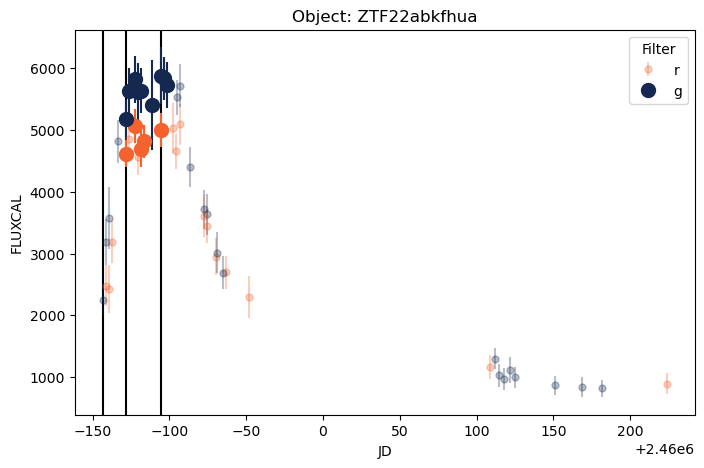

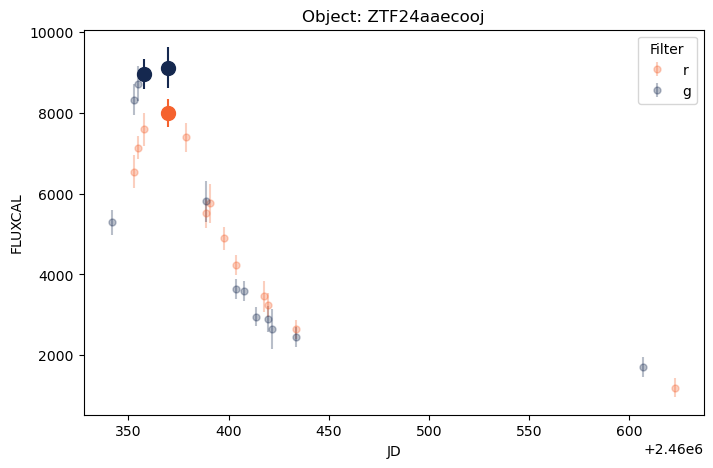

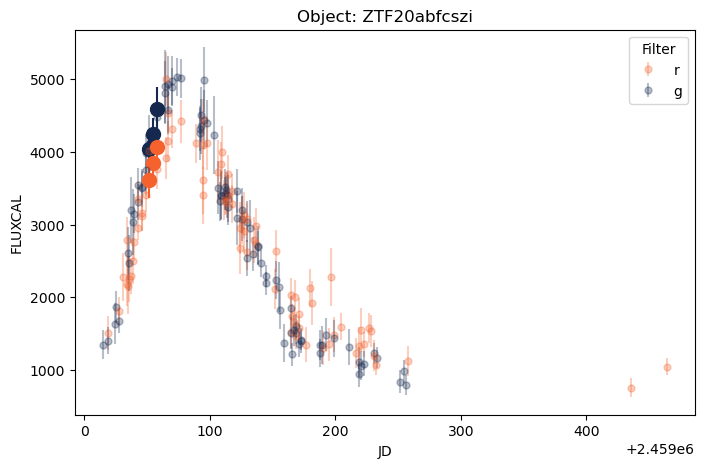

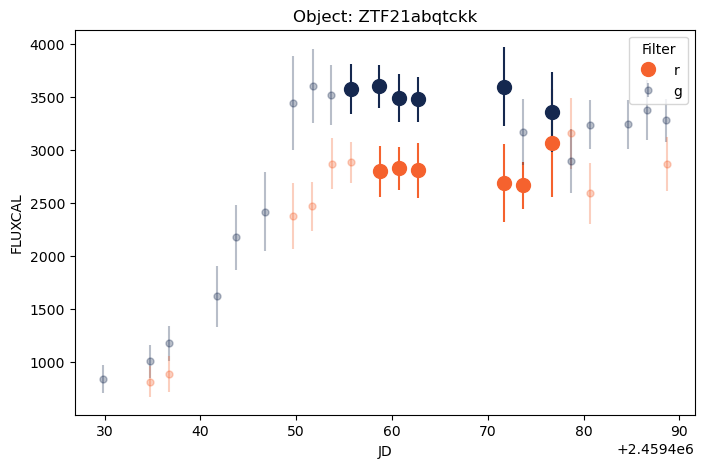

In [8]:
plot_fluxcal(tde_lcs, pred_tdes.alertId.tolist())


## Loop over training-predicting several times
Obtain values of when each TDE is first identified as such

In [9]:
# Load all LCs
all_data_lcs = load_lcs()

In [10]:
def extract_info(tde_lc, pred_tdes_alertid):
    """
    Extract info related to the moment of first identification of a TDE wrt first detection and peak detection
    """
    sorted_indices = tde_lc.jd.argsort()
    sorted_jd = tde_lc.jd[sorted_indices]
    sorted_candid = tde_lc.candid[sorted_indices]
    sorted_flux = tde_lc.FLUXCAL[sorted_indices]

    # Get first identified alert
    idx_first_identified_alert = next((i for i, x in enumerate(sorted_candid) if x in pred_tdes_alertid), None)
    jd_first_identif_alert = sorted_jd[idx_first_identified_alert]
    
    
    # Get time from detection to identification
    time_identif_since_first_detection = jd_first_identif_alert - sorted_jd[0]
    
    # Get time of identification before the peak (how long before the peak)
    time_identif_before_peak = sorted_jd[np.argmax(sorted_flux)] - jd_first_identif_alert

    # Get time from detection to peak
    rise_time = sorted_jd[np.argmax(sorted_flux)] - sorted_jd[0]

    return time_identif_since_first_detection, time_identif_before_peak, rise_time

In [11]:
rows_df = []
for seed in range(50):  # Several loops of training predicting

    # Train and get list of TDE candidates from the testing sample
    label_pred, label_test, test_mask = train_and_predict(feat_data, feature_matrix, labels, seed, verbose = False)
    pred_tdes = feat_data[test_mask][(label_test == 'TDE') & (label_pred == 'TDE')]   # Select TDEs identified by the model
    # pred_tdes = feat_data[test_mask][(label_pred == 'TDE')]   # Select TDEs identified by the model
    pred_tdes_alertid = pred_tdes.alertId.tolist()

    for objectId in pred_tdes.objectId.unique().tolist():
    	tde_lc = all_data_lcs[all_data_lcs.objectId == objectId].iloc[0]
    
    	# Extract info of interest
    	t_since_first_det, t_before_peak, rise_time = extract_info(tde_lc, pred_tdes_alertid)
    
    	# Append one row (this can happen multiple times for same objectId)
    	rows_df.append({
    		"objectId": objectId,
    		"t_since_first_det": t_since_first_det,
    		"t_before_peak": t_before_peak,
    		"rise_time": rise_time
    	})
    
# Convert to DataFrame
df_stats_identif_speed = pd.DataFrame(rows_df)


In [12]:
df_stats_identif_speed

,objectId,t_since_first_det,t_before_peak,rise_time
0,ZTF22abegjtx,29.937222,26.979236,56.916458
1,ZTF20abfcszi,36.936979,22.004965,58.941944
2,ZTF22aaigqsr,16.991238,5.001979,21.993218
3,ZTF22abkfhua,14.924803,23.041898,37.966701
4,ZTF24aaecooj,16.125637,11.882951,28.008588
...,...,...,...,...
115,ZTF22abkfhua,14.924803,23.041898,37.966701
116,ZTF22abegjtx,29.937222,26.979236,56.916458
117,ZTF20acqoiyt,21.009352,0.000000,21.009352
118,ZTF22abegjtx,29.937222,26.979236,56.916458


In [13]:
df_stats_identif_speed.groupby("objectId").mean().reset_index()

,objectId,t_since_first_det,t_before_peak,rise_time
0,ZTF20abfcszi,36.947545,21.994400,58.941944
1,ZTF20acnznms,20.791678,27.109861,47.901539
2,ZTF20acqoiyt,21.009352,0.000000,21.009352
3,ZTF21aaaokyp,34.896381,2.107057,37.003437
4,ZTF21abqtckk,25.887639,-3.997500,21.890139
5,ZTF22aaigqsr,17.395539,4.597678,21.993218
6,ZTF22abegjtx,34.716601,22.199858,56.916458
7,ZTF22abkfhua,14.924803,23.041898,37.966701
8,ZTF23aapyidj,15.978646,12.979352,28.957998
9,ZTF24aaecooj,19.520766,8.487822,28.008588


## Analyse results and plot

TypeError: Axis._set_axes_scale() missing 1 required positional argument: 'value'

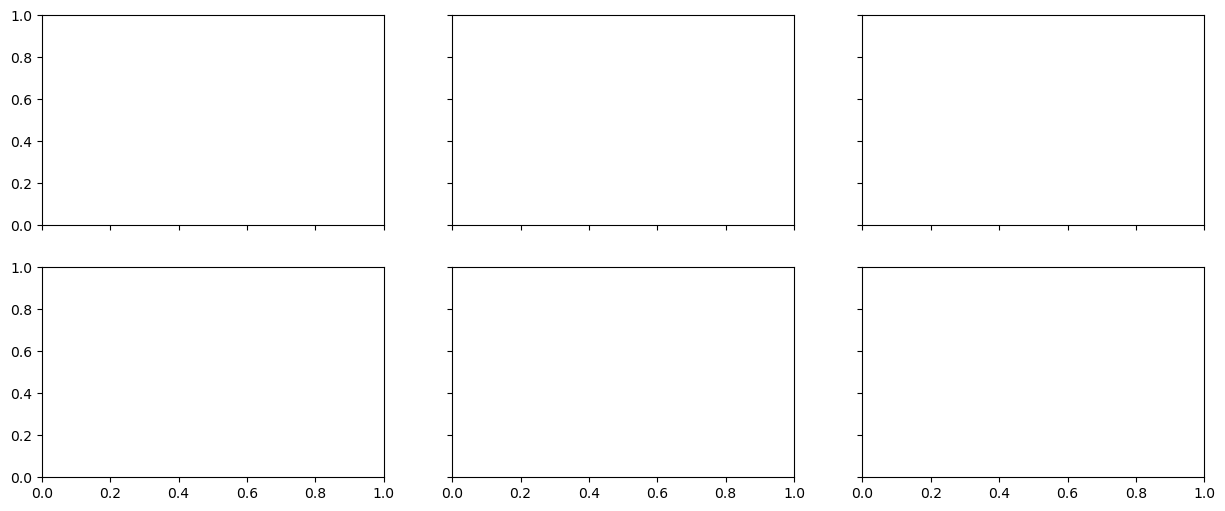

In [14]:
import matplotlib.pyplot as plt

# Create normalized column
df_stats_identif_speed['t_since_first_det_norm'] = df_stats_identif_speed['t_since_first_det'] / df_stats_identif_speed['rise_time']

# Group by objectId
df_means = df_stats_identif_speed.groupby('objectId', as_index=False).mean()

# Set up 2 rows and 3 columns, shared x and y axes
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex='col', sharey='row')

# Titles and x labels
titles = ['Time since first detection', 'Time before peak', 'Fraction of rise until identification']
xlabels = ['Days', 'Days', 'Fraction of rise time']

# First row: all data
axes[0, 0].hist(df_stats_identif_speed['t_since_first_det'], bins=30, histtype='step', color='blue')
axes[0, 1].hist(df_stats_identif_speed['t_before_peak'], bins=30, histtype='step', color='blue')
axes[0, 2].hist(df_stats_identif_speed['t_since_first_det_norm'], bins=30, histtype='step', color='blue')
# Second plot addition
axes[0, 1].axvline(0, color='black', linestyle='--', alpha=0.7)
# Third plot additions
axes[0, 2].set_xlim(left=0)
axes[0, 2].axvline(1, color='black', linestyle='--', alpha=0.7)

# Second row: averaged by objectId
axes[1, 0].hist(df_means['t_since_first_det'], bins=30, histtype='step', color='red')
axes[1, 1].hist(df_means['t_before_peak'], bins=30, histtype='step', color='red')
axes[1, 2].hist(df_means['t_since_first_det_norm'], bins=30, histtype='step', color='red')
# Second plot addition
axes[1, 1].axvline(0, color='black', linestyle='--', alpha=0.7)
# Third plot additions
axes[1, 2].set_xlim(left=0)
axes[1, 2].axvline(1, color='black', linestyle='--', alpha=0.7)

# Add titles and x labels
for i, ax in enumerate(axes[0]):
	ax.set_title(titles[i], fontsize=14)
for i, ax in enumerate(axes[1]):
	ax.set_xlabel(xlabels[i], fontsize=12)

# Y label for rows
axes[0, 0].set_ylabel("All data")
axes[1, 0].set_ylabel("Avg per object")

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_stats_identif_speed['t_since_first_det'],
            df_stats_identif_speed['t_before_peak'],
            alpha=0.7, edgecolors='k')

plt.xlabel('Time since first detection (days)')
plt.ylabel('Time before peak (days)')
plt.title('TDE candidate identification: Time since first detection vs Time before peak')
plt.grid(True)
plt.tight_layout()
plt.show()